# Comparing MC-Dropout and Moment Propagation

In [1]:
%load_ext autoreload

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
BASE_PATH = os.path.join(os.getcwd(), "..", "..")
MODULES_PATH = os.path.join(BASE_PATH, "modules")
DATASET_PATH = os.path.join(BASE_PATH, "datasets")

In [4]:
sys.path.append(MODULES_PATH)

In [5]:
from bayesian import McDropout, MomentPropagation
from models import fchollet_cnn, setup_growth
from data import BenchmarkData, DataSetType

In [6]:
mnist = BenchmarkData(DataSetType.MNIST, os.path.join(DATASET_PATH, "mnist"), dtype=np.float32)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(mnist.inputs, mnist.targets)

In [8]:
# Setup parameters and environment
setup_growth()
num_classes = len(np.unique(mnist.targets))
epochs = 120
batch_size = 80

# Create and fit model
base_model = fchollet_cnn(output=num_classes)
base_model.compile(optimizer="adadelta", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
base_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)

1 Physical GPU's,  1 Logical GPU's
Epoch 1/120
657/657 [==============================] - 11s 16ms/step - loss: 15.4691 - accuracy: 0.1990
Epoch 2/120
657/657 [==============================] - 4s 6ms/step - loss: 5.8702 - accuracy: 0.3316
Epoch 3/120
657/657 [==============================] - 3s 5ms/step - loss: 3.2131 - accuracy: 0.3765
Epoch 4/120
657/657 [==============================] - 4s 5ms/step - loss: 2.3162 - accuracy: 0.3931
Epoch 5/120
657/657 [==============================] - 4s 5ms/step - loss: 2.0010 - accuracy: 0.4093
Epoch 6/120
657/657 [==============================] - 4s 5ms/step - loss: 1.8380 - accuracy: 0.4347
Epoch 7/120
657/657 [==============================] - 4s 5ms/step - loss: 1.7315 - accuracy: 0.4634
Epoch 8/120
657/657 [==============================] - 4s 5ms/step - loss: 1.6396 - accuracy: 0.4914
Epoch 9/120
657/657 [==============================] - 4s 5ms/step - loss: 1.5609 - accuracy: 0.5173
Epoch 10/120
657/657 [==============================]

657/657 [==============================] - 4s 5ms/step - loss: 0.4504 - accuracy: 0.8716
Epoch 82/120
657/657 [==============================] - 4s 5ms/step - loss: 0.4428 - accuracy: 0.8731
Epoch 83/120
657/657 [==============================] - 4s 5ms/step - loss: 0.4395 - accuracy: 0.8734
Epoch 84/120
657/657 [==============================] - 3s 5ms/step - loss: 0.4361 - accuracy: 0.8758
Epoch 85/120
657/657 [==============================] - 4s 5ms/step - loss: 0.4303 - accuracy: 0.8779
Epoch 86/120
657/657 [==============================] - 3s 5ms/step - loss: 0.4324 - accuracy: 0.8730
Epoch 87/120
657/657 [==============================] - 3s 5ms/step - loss: 0.4243 - accuracy: 0.8786
Epoch 88/120
657/657 [==============================] - 3s 5ms/step - loss: 0.4220 - accuracy: 0.8820
Epoch 89/120
657/657 [==============================] - 3s 5ms/step - loss: 0.4235 - accuracy: 0.8800
Epoch 90/120
657/657 [==============================] - 3s 5ms/step - loss: 0.4138 - accuracy: 

In [9]:
base_model.evaluate(x_test, y_test)

547/547 [==============================] - 5s 9ms/step - loss: 0.1476 - accuracy: 0.9601


[0.14763230085372925, 0.9601143002510071]

# Compare Entropy values

In [10]:
comp_inputs = x_test[:100]
comp_targets = y_test[:100]

In [12]:
def create_mean_df(values, targets):
    """
        Average values per class and plot values into single plot
        
        Parmeters:
            values (numpy.ndarray):
            targets (numpy.ndarray): 
    """
    unique_targets = np.unique(targets)
    
    # Calculate mean values per class
    mean_values = []
    for u_target in unique_targets:
        selector = (targets == u_target)
        target_values = values[selector]
        mean_values.append(np.mean(target_values))
    
    # Plot values
    mean_values = np.array(mean_values)
    return pd.DataFrame({"targets": unique_targets, "mean_values": mean_values})

In [13]:
def plot_mean_df(data, x_label, y_label):
    sns.barplot(data=df, x="targets", y="mean_values")
    plt.xlabel(x_label)
    plt.ylabel(y_label)

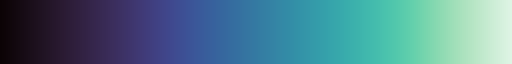

In [23]:
sns.color_palette("mako", as_cmap=True)

In [61]:
# MC Dropout Model
mc_model = McDropout(base_model)
mc_pred = mc_model(comp_inputs, sample_size=500)
print("Pred. shape: {} '(num_datapoints, sample_size, target_size)'".format(mc_pred.shape))

Pred. shape: (100, 500, 10) '(num_datapoints, sample_size, target_size)'


In [62]:
# MC Dropout NLL
mc_nll = mc_model.nll(mc_pred, comp_targets)
df_mc_nll = create_mean_df(mc_nll, comp_targets)
df_mc_nll.insert(1, "metric", "NLL")
df_mc_nll.insert(1, "model", "MC Dropout")

In [63]:
# MC Dropout Entropy
mc_entropy = mc_model.entropy(mc_pred)
df_mc_entropy = create_mean_df(mc_entropy, comp_targets)
df_mc_entropy.insert(1, "metric", "Entropy")
df_mc_entropy.insert(1, "model", "MC Dropout")

In [64]:
# MP Model
mp_model = MomentPropagation(base_model)
mp_exp, mp_var = mp_model(comp_inputs)

In [65]:
# MP NLL
mp_nll = mp_model.nll(mp_exp, comp_targets)
df_mp_nll = create_mean_df(mp_nll, comp_targets)
df_mp_nll.insert(1, "metric", "NLL")
df_mp_nll.insert(1, "model", "Moment Propagation")

In [66]:
# MP entropy
mp_entropy = mp_model.entropy(mp_exp)
df_mp_entropy = create_mean_df(mp_entropy, comp_targets)
df_mp_entropy.insert(1, "metric", "Entropy")
df_mp_entropy.insert(1, "model", "Moment Propagation")

In [82]:
metrics_entropy = pd.concat([df_mc_entropy, df_mp_entropy])
metrics_nll = pd.concat([df_mc_nll, df_mp_nll])

Text(0.5, 1.0, 'NLL Comparison')

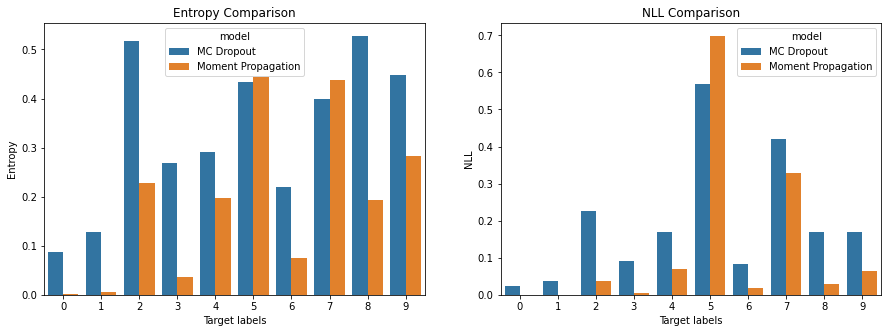

In [95]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(ax=axes[0], data=metrics_entropy, y="mean_values", x="targets", hue="model")
axes[0].set_xlabel("Target labels")
axes[0].set_ylabel("Entropy")
axes[0].set_title("Entropy Comparison")

sns.barplot(ax=axes[1], data=metrics_nll, y="mean_values", x="targets", hue="model")
axes[1].set_xlabel("Target labels")
axes[1].set_ylabel("NLL")
axes[1].set_title("NLL Comparison")